In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import signac
import cg_pyrosetta
import numpy as np
import pandas as pd
import copy
import os
import flow
import analyze_foldamers
import matplotlib.pyplot as plt
import mdtraj as md
from flow import FlowProject
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({"font.size" : 15})

In [3]:
project = signac.get_project()
schema = project.detect_schema()
sc_sizes, reps = schema.items()
sc_sizes = list(sc_sizes[1][float])
sc_sizes.sort()

In [4]:
sc_sizes

[0.5,
 0.8888888888888888,
 1.2777777777777777,
 1.6666666666666667,
 2.0555555555555554,
 2.4444444444444446,
 2.8333333333333335,
 3.2222222222222223,
 3.611111111111111,
 4.0]

In [5]:
for sc_size in sc_sizes:
    print("SC Size = " + str(round(sc_size, 4)))
    for job in project.find_jobs({'sc_size':sc_size}):
        print(job.id)

SC Size = 0.5
01a33184356aca40482e6f4ca8238480
abf72ee214e11a1bfc233ba4029bbce9
e909bc4ff3ba246c40cf1d339f6da735
a46f9d1f8419b5aaf1b366e468877e98
fddb5a03ce4054bbaa9f2304832901f3
a24c2b0b872b566516ef5aefaf693745
4e519210ce2019aabb0420d49f466a4f
c041aa32b1980b2d3ddc1fedbfa37a73
0d5e2ed8674bd6295f054de6a7a54a44
be3e60c5f7bc937904c97347db675c8f
ef42543d532bd8ca561f383b7e20b56c
69ced857dbcf9da9522fc83868bacdce
fbc6c8b7530a44f4892b977fc884dfd8
556cbee4e4c22f741c817230d77b85b5
21751d80204d43046ec9173557795a83
ca0d0ec6114a37d112c042d14c38d13f
92bc2d34eaa96b4670e9da3231a6cac9
6016baf97d0160c6174dc0587d2aa81d
096dbd98a799e5fccf1b86a7b156765b
b9b24fc6d29b7f604b4c014f3fcbc78c
5389d83f0b09f2725d369d4815584306
da0824a85621ae143e30165bff2105c3
8c2b03170fabb3a47960221c13a61e79
bafa24030cf33103ec83785d2b5bed38
a9325775fbec3f7e766492554a3058c8
bfbf1b1ec07308cdc28c48b8b2c021c6
09eca16ec26de9ac06ba1eb279b5cd74
2fde90e0ab1e45e35b8b69e7f321f22f
dd77bf9527d51ec322ad982a1489ad0e
c1759ce7ca5ffc70a4b4f9ed2a07b

In [6]:
kts = np.array([10 * ( 0.9 ) ** i for i in range(50)])
out_steps = np.array([10000 * i for i in range(50) ])
print(kts)

[10.          9.          8.1         7.29        6.561       5.9049
  5.31441     4.782969    4.3046721   3.87420489  3.4867844   3.13810596
  2.82429536  2.54186583  2.28767925  2.05891132  1.85302019  1.66771817
  1.50094635  1.35085172  1.21576655  1.09418989  0.9847709   0.88629381
  0.79766443  0.71789799  0.64610819  0.58149737  0.52334763  0.47101287
  0.42391158  0.38152042  0.34336838  0.30903154  0.27812839  0.25031555
  0.225284    0.2027556   0.18248004  0.16423203  0.14780883  0.13302795
  0.11972515  0.10775264  0.09697737  0.08727964  0.07855167  0.0706965
  0.06362685  0.05726417]


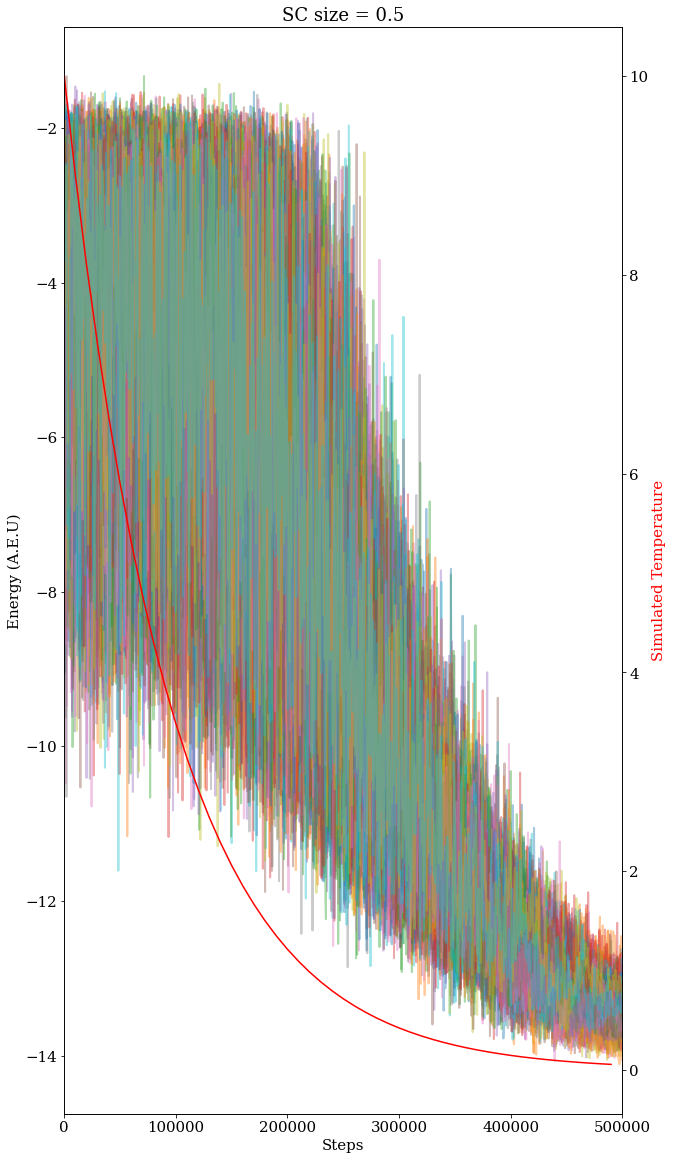

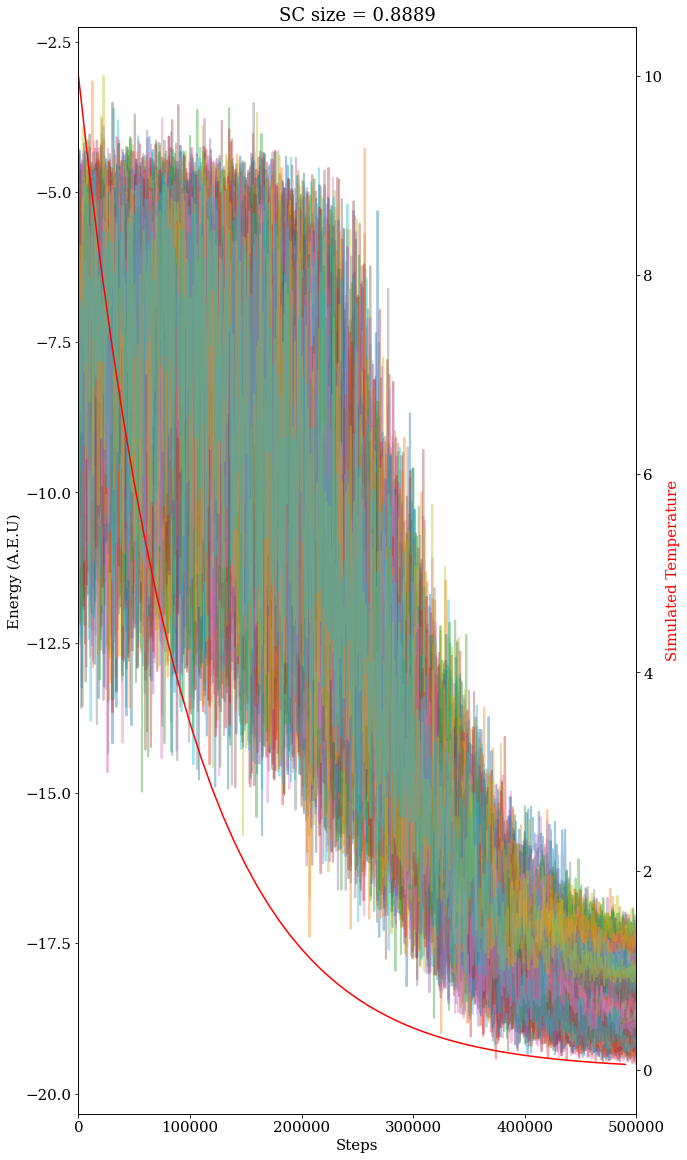

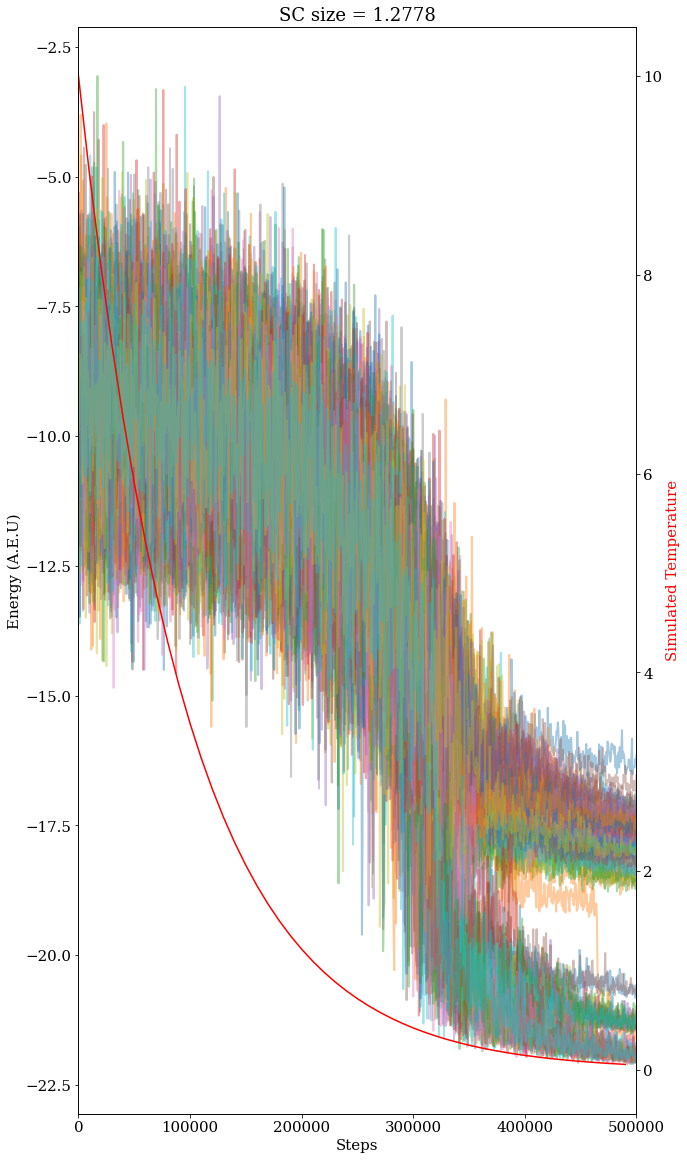

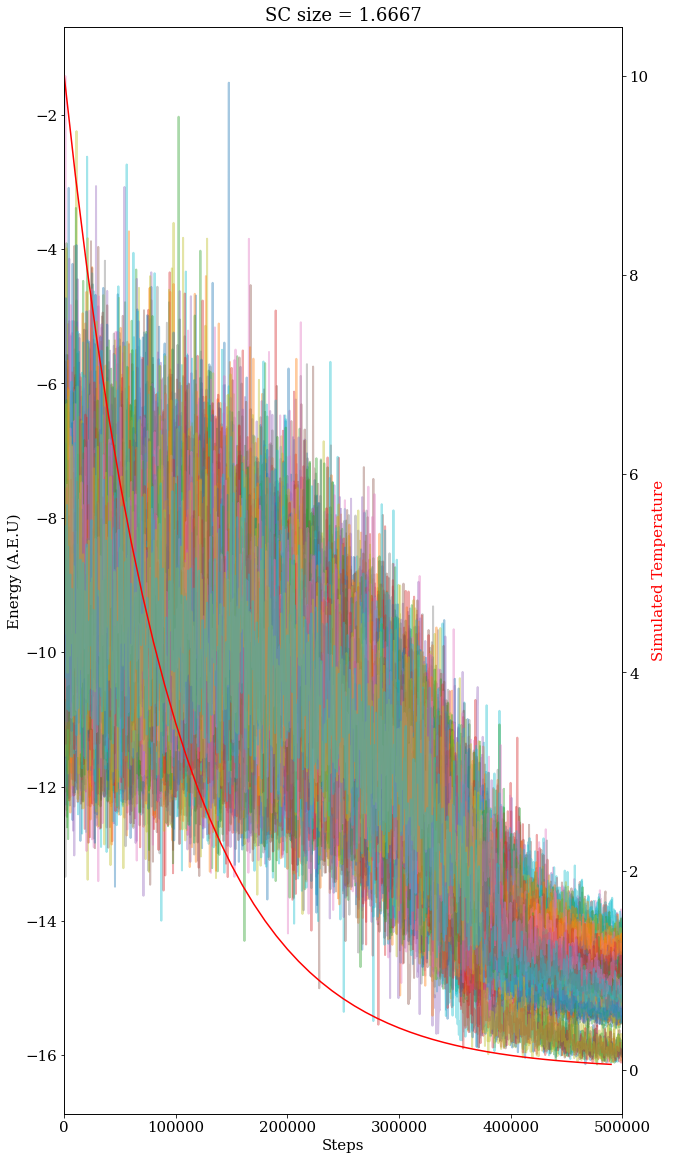

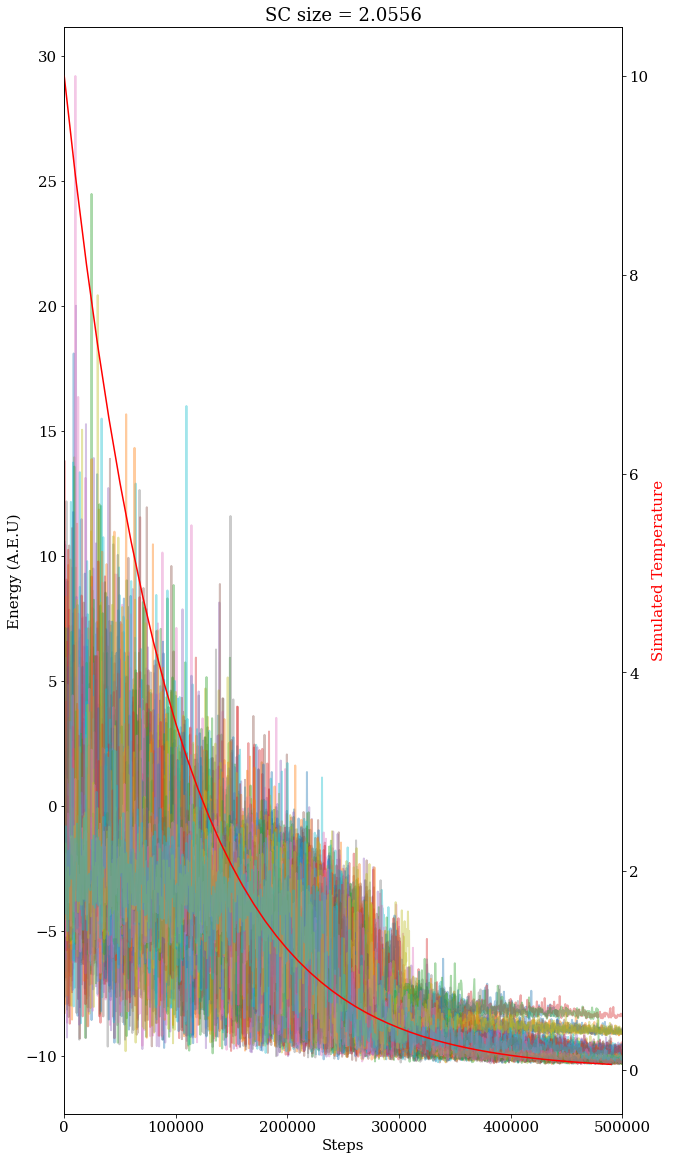

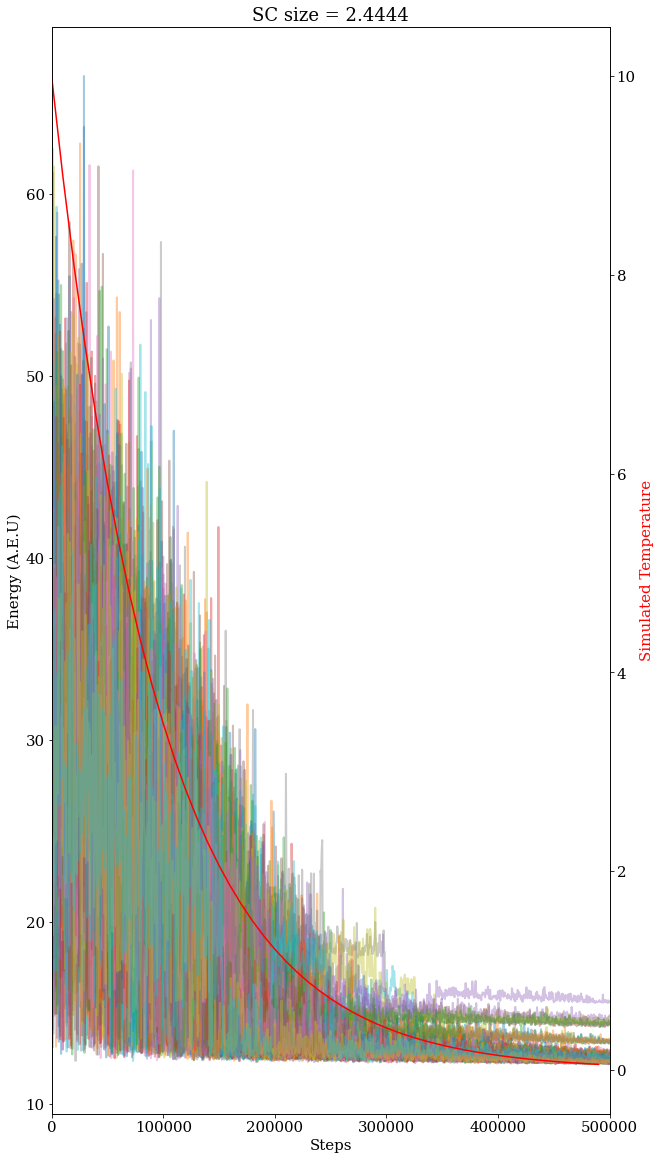

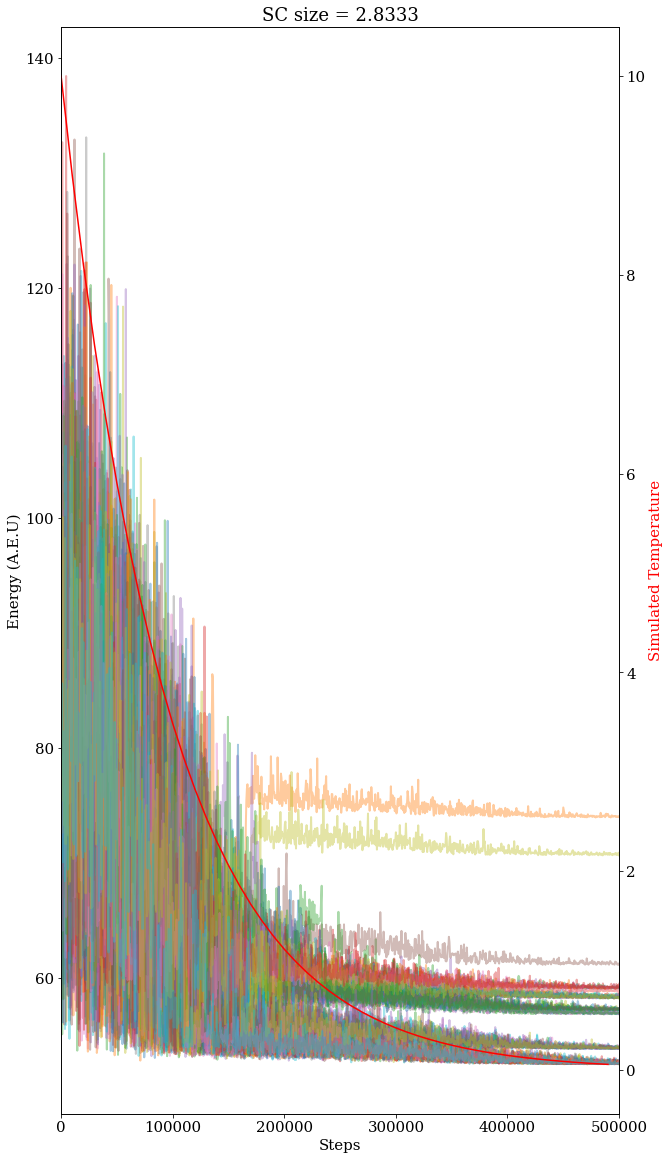

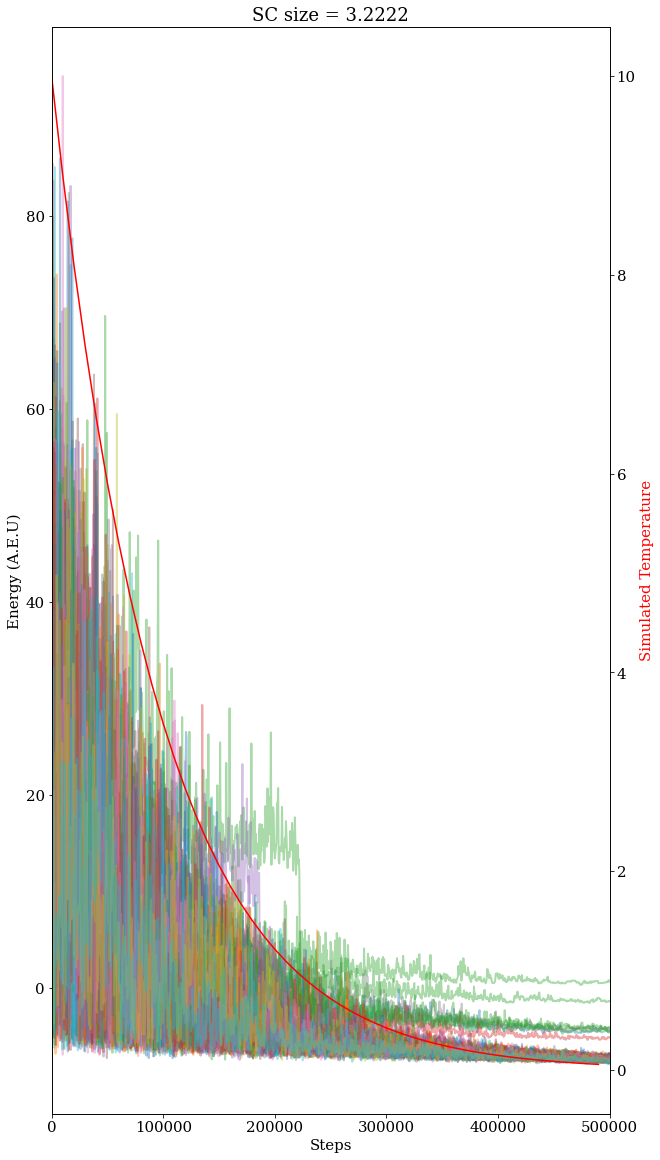

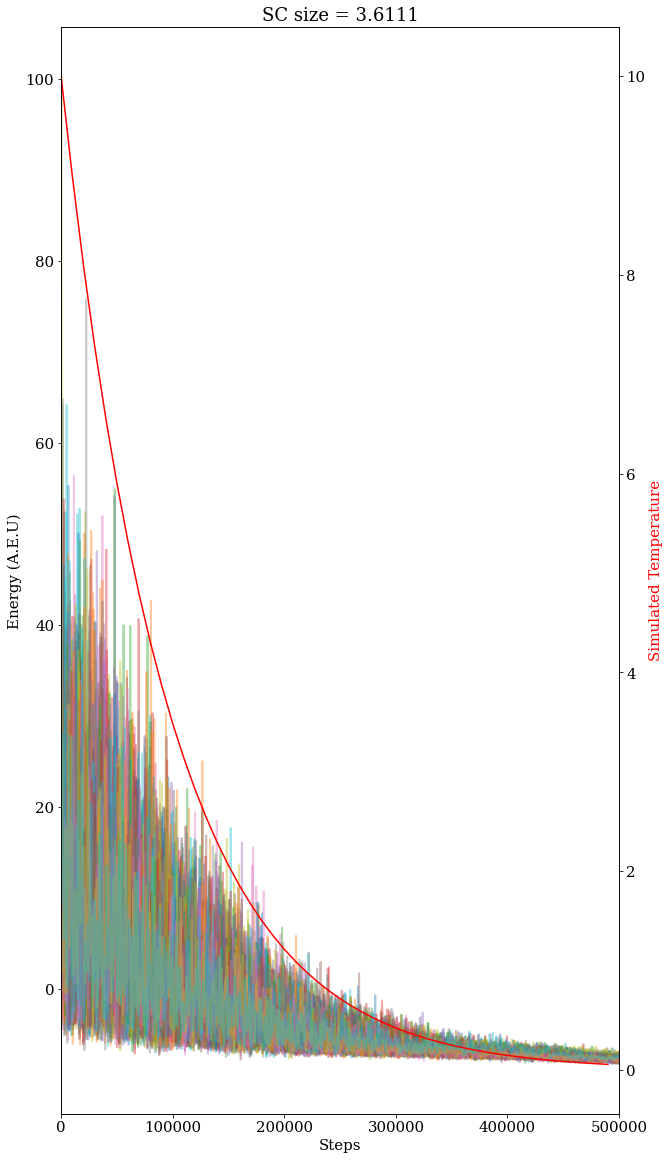

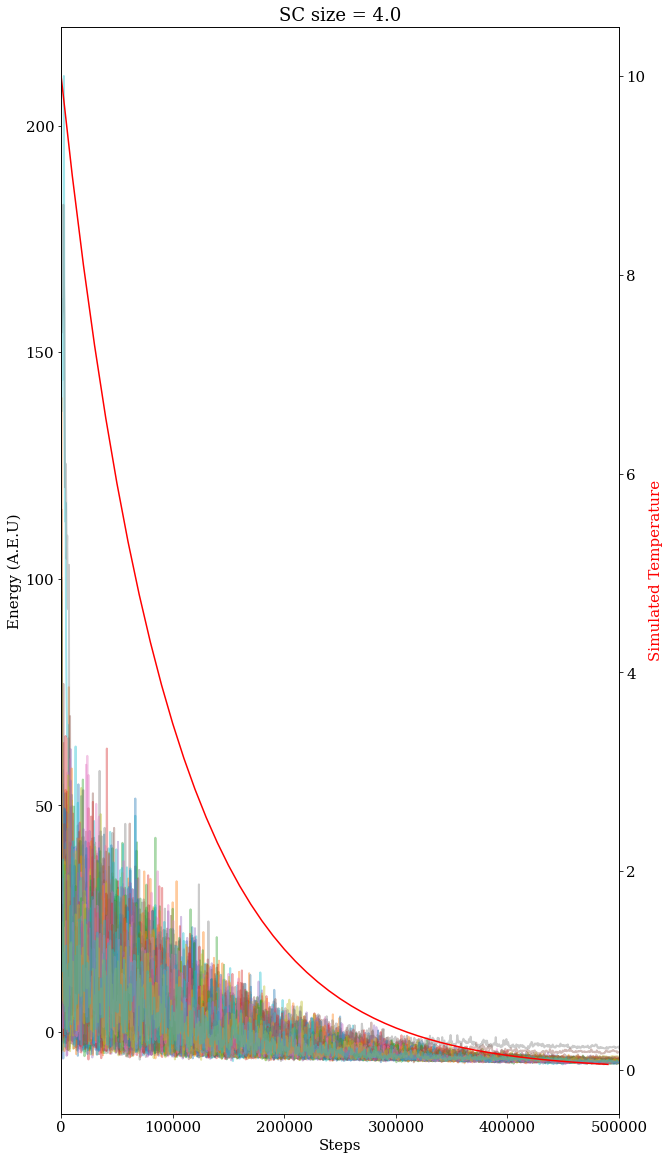

In [7]:
for sc_size in sc_sizes:
    fig, ax1 = plt.subplots(1,1,figsize = [10,20])
    ax2 = ax1.twinx()
    ax2.plot(out_steps, kts, 'r')
    ax2.set_xlim([0, 500000])
    ax2.set_ylabel("Simulated Temperature", color = 'r')
    for job in project.find_jobs({'sc_size':sc_size}):
        energy_file = job.fn("energies.txt")
        if os.path.isfile(energy_file):
            energies = pd.read_csv(energy_file, header=None)
            ax1.plot(energies.values[:,0], energies.values[:,1], alpha = .4, lw=2)
            ax1.set_xlabel("Steps")
            ax1.set_ylabel("Energy (A.E.U)")
            # ax1.set_xlim([0, 500000])
            ax1.set_title("SC size = " + str(round(job.sp['sc_size'],4)))
        else:
            print("sc_size", sc_size, "hasn't started yet")    


In [8]:
# DBSCAN Clustering
test = [sc_sizes[2]] #temporary
for sc_size in test:
    traj_file_list = []
    all_energies = []
    for job in project.find_jobs({'sc_size':sc_size}):
        structure_file = job.fn('trajectory.pdb')
        traj_file_list.append(structure_file)
        energy_file = job.fn('energies.txt')
        energies = pd.read_csv(energy_file)
        all_energies.extend(energies.values[:, 1])
    all_energies = np.array(all_energies)

In [ ]:
medoid_positions, cluster_sizes, cluster_rmsd, n_noise, labels, silhouette_avg, original_indices = analyze_foldamers.cluster.\
get_cluster_medoid_positions_DBSCAN(traj_file_list, eps = 0.15, min_samples = 30, frame_start = 700, frame_stride = 1, output_dir="cluster_output", cgmodel=None, plot_silhouette=True, filter=True, filter_ratio = 0.5, return_original_indices = True)

In [ ]:
len(cluster_sizes)

In [ ]:
original_indices

In [ ]:
labels.shape

In [ ]:
clusters = np.unique(labels)
for i in clusters[1:]:
    cluster_indices = np.where(labels == i)[0]
    cluster_energies = all_energies[cluster_indices]
    min_energy = np.mean(cluster_energies)
    std_energy = np.std(cluster_energies)
    plt.scatter(min_energy, std_energy, s=60)
plt.legend(["Cluster "+ str(a) for a in clusters[1:]])

In [ ]:
plt.figure(figsize = [5, 5], dpi=100)
clusters = np.unique(labels)
energy_stdevs = []
for i in clusters[1:]:
    cluster_indices = np.where(labels == i)[0]
    cluster_energies = all_energies[cluster_indices]
    avg_energy = np.mean(cluster_energies)
    energy_stdevs.append(std_energy)
    plt.scatter(cluster_rmsd[i]/np.sqrt(cluster_sizes[i]), avg_energy, s=60)
    plt.xlabel("Cluster RMSF")
    plt.ylabel("Cluster Mean Energy")
plt.legend(["Cluster "+ str(a) for a in clusters[1:]])

In [ ]:
energy_stdevs

In [ ]:
cluster_rmsd

In [17]:
# RMSD (to mediod centers) vs Energy
sc_sizes = [1.0]

n_clusters = 2
avg_cluster_scores = []
for sc_size in sc_sizes:
    plt.figure()
    traj_file_name_list = []
    all_energies = []
    for job in project.find_jobs({'sc_size':sc_size}):
            energy_file = job.fn("energies.txt")
            if os.path.isfile(energy_file):
                energies = pd.read_csv(energy_file, header=None)
                all_energies.extend(energies.values[:, 1])
                structure_file = job.fn("structure.txt")
                struct_loc = pd.read_csv(structure_file, header=None)
                traj_file_name_list.extend([job.fn(file) for file in struct_loc[1].values])
            else:
                print("sc_size", sc_size, "hasn't started yet")
    traj = md.load(traj_file_name_list)
    medoid_positions, cluster_sizes, cluster_rmsd, cluster_indices, silhouette_avg = analyze_foldamers.cluster.\
    get_cluster_medoid_positions_KMedoids(traj_file_name_list, n_clusters = n_clusters, output_dir="cluster_output", cgmodel=None, plot_silhouette=True)
    traj.save_pdb("test.pdb")
    

ValueError: No trajectories specified. filename_or_filenames was an empty list

<Figure size 432x288 with 0 Axes>

In [ ]:
# Distribution of minimum energy structures
sorted_energies = copy.deepcopy(all_energies)
sorted_energies.sort()
plt.hist(sorted_energies[:1000], bins=30)

In [ ]:
silhouette_avg

In [ ]:
plt.figure()
for i in range(n_clusters):
    medoid_mdtraj = md.load("cluster_output/medoid_" + str(i) + ".pdb")
    rmsds_medoid_i = md.rmsd(traj, medoid_mdtraj)
    plt.scatter(rmsds_medoid_i[cluster_indices[i]], [all_energies[a] for a in cluster_indices[i]], s = 1)
    plt.xlabel("RMSD to Mediod " + str(i+1))
    plt.ylabel("Energies")
    plt.title(job.sp)
plt.legend(["cluster " + str(i + 1) for i in range(n_clusters)])
plt.savefig(job.fn("kmedoid_rmsd_energy_scatter.jpg"), dpi=600)
    

In [ ]:
legend_list.extend(["Structure A", "Structure B", "Structure C", "Structure D", "Structure E", "Structure F"])
len(legend_list)

In [ ]:
# RMSD (to minimum energy structure) vs Energy

for sc_size in sc_sizes:
    plt.figure(figsize = [20,10])
    all_traj = md.load(traj_file_name_list)

    for job in project.find_jobs({'sc_size':sc_size}):
        # Get MC traj
        structure_file = job.fn("structure.txt")
        struct_loc = pd.read_csv(structure_file, header=None)
        traj = md.load([job.fn(file) for file in struct_loc[1].values])

        # Get minimum energy structure
        energy_file = job.fn("energies.txt")
        energies = pd.read_csv(energy_file, header=None).values[:,1]
        
        min_energy_index = np.where(all_energies == np.min(all_energies))
        min_energy_struct = all_traj.slice(min_energy_index)

        # Compute RMSDs to trajectory
        rmsds_medoid_i = md.rmsd(traj, min_energy_struct)

        plt.scatter(rmsds_medoid_i, energies, s = 1)
        
        
        
    # Get ALL MC traj
    structure_file = job.fn("structure.txt")
    struct_loc = pd.read_csv(structure_file, header=None)
    traj = md.load(traj_file_name_list)

    # Get minimum energy structure
    min_energy_index= np.where(all_energies == np.min(all_energies))
    min_energy_struct = traj.slice(min_energy_index)

    # Compute RMSDs to trajectory
    rmsds_medoid_i = md.rmsd(traj, min_energy_struct)
    
    # plt.figure(figsize = [20,10])
    # plt.scatter(rmsds_medoid_i, all_energies, s = 1)

        
    # Minimum energy structure
    
    minimum_index = min_energy_index[0][0]
    poi_1 = np.where(all_energies == sorted_energies[450])[0][0]
    poi_2 = np.where(all_energies == sorted_energies[471])[0][0]
    poi_3 = np.where(all_energies == sorted_energies[1400])[0][0]
    poi_4 = np.where(all_energies == sorted_energies[2300])[0][0]
    poi_5 = np.where(all_energies == sorted_energies[700])[0][0]
    
    min_energy_struct.save_pdb("overall_minimim.pdb")
    plt.scatter(rmsds_medoid_i[minimum_index], all_energies[minimum_index], c = 'r', s = 150, marker = 'D')
    plt.scatter(rmsds_medoid_i[poi_1], all_energies[poi_1], c = 'g', s = 150, marker = 'D')
    plt.scatter(rmsds_medoid_i[poi_2], all_energies[poi_2], c = 'y', s = 150, marker = 'D')
    plt.scatter(rmsds_medoid_i[poi_3], all_energies[poi_3], c = 'k', s = 150, marker = 'D')
    plt.scatter(rmsds_medoid_i[poi_4], all_energies[poi_4], c = 'm', s = 150, marker = 'D')
    plt.scatter(rmsds_medoid_i[poi_5], all_energies[poi_5], c = 'C1', s = 150, marker = 'D')
    legend_list = ["rep " + str(i) for i in range(10)]
    legend_list.extend(["Structure A", "Structure B", "Structure C", "Structure D", "Structure E", "Structure F"])
    plt.legend(legend_list)
    plt.xlabel("RMSD to Minimum Energy Structure")
    plt.ylabel("Energies")
    plt.savefig("min_energy_rmsd_energy_scatter.jpg", dpi=600)



In [ ]:
# Minimum energy structure

minimum_index = min_energy_index[0][0]
poi_1 = np.where(all_energies == sorted_energies[450])[0][0]
poi_2 = np.where(all_energies == sorted_energies[471])[0][0]
poi_3 = np.where(all_energies == sorted_energies[1400])[0][0]
poi_4 = np.where(all_energies == sorted_energies[2300])[0][0]
poi_5 = np.where(all_energies == sorted_energies[700])[0][0]

print("Minimum energy structure location:", traj_file_name_list[minimum_index])
print("Point of Interest 1 location:", traj_file_name_list[poi_1])
print("Point of Interest 2 location:", traj_file_name_list[poi_2])
print("Point of Interest 3 location:", traj_file_name_list[poi_3])
print("Point of Interest 4 location:", traj_file_name_list[poi_4])
print("Point of Interest 5 location:", traj_file_name_list[poi_5])



min_energy_struct.save_pdb("overall_minimim.pdb")
plt.figure(figsize = [20,10])
plt.scatter(rmsds_medoid_i, all_energies, s = 10, label = None)
plt.scatter(rmsds_medoid_i[minimum_index], all_energies[minimum_index], c = 'r', s = 150, marker = 'D')
plt.scatter(rmsds_medoid_i[poi_1], all_energies[poi_1], c = 'g', s = 150, marker = 'D')
plt.scatter(rmsds_medoid_i[poi_2], all_energies[poi_2], c = 'y', s = 150, marker = 'D')
plt.scatter(rmsds_medoid_i[poi_3], all_energies[poi_3], c = 'k', s = 150, marker = 'D')
plt.scatter(rmsds_medoid_i[poi_4], all_energies[poi_4], c = 'm', s = 150, marker = 'D')
plt.scatter(rmsds_medoid_i[poi_5], all_energies[poi_5], c = 'C1', s = 150, marker = 'D')
plt.legend(["All structures", "Structure A", "Structure B", "Structure C", "Structure D", "Structure E", "Structure F"])
plt.xlabel("RMSD to Minimum Energy Structure")
plt.ylabel("Energy (A.E.U)")
plt.savefig("min_energy_rmsd_energy_scatter.jpg", dpi=600)

In [ ]:
rmsd_matrix = np.zeros([traj.n_frames, traj.n_frames])
for i in range(traj.n_frames):
    rmsd_matrix[:, i] = md.rmsd(traj, traj.slice(i))

In [ ]:
plt.hist(rmsd_matrix.flatten(), bins = 100)
plt.ylabel("Count")
plt.xlabel("RMSDs")